In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# for a start, let's use the imdb reviews dataset
from tensorflow.keras.datasets import imdb

2022-06-27 22:58:59.406114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 22:58:59.406176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_data(percentage_of_sentences=None):
    # Load the data
    (sentences_train, y_train), (sentences_test, y_test) = imdb.load_data()
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(sentences_train))
        sentences_train = sentences_train[:len_train]
        y_train = y_train[:len_train]
        
        len_test = int(percentage_of_sentences/100*len(sentences_test))
        sentences_test = sentences_test[:len_test]
        y_test = y_test[:len_test]
            
    # Load the {interger: word} representation
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    for i, w in enumerate(['<PAD>', '<START>', '<UNK>', '<UNUSED>']):
        word_to_id[w] = i

    id_to_word = {v:k for k, v in word_to_id.items()}

    # Convert the list of integers to list of words (str)
    X_train = [' '.join([id_to_word[_] for _ in sentence[1:]]) for sentence in sentences_train]
    
    return X_train


### Just run this cell to load the data
data = load_data(percentage_of_sentences=10)

In [3]:
# let's see what are the most frequent words
# the idea is to start by learning to predict those words first

In [9]:
df = pd.DataFrame({
    "word" : (" ".join(data)).split()
})
df.head()

,word
0,this
1,film
2,was
3,just
4,brilliant


In [10]:
df.shape

(600004, 1)

In [11]:
df["count"] = 1
df.head()

,word,count
0,this,1
1,film,1
2,was,1
3,just,1
4,brilliant,1


In [48]:
df_count = df.groupby(by="word", as_index=False).count().sort_values("count", ascending=False).reset_index(drop=True)
df_count.head()

,word,count
0,the,34117
1,and,16560
2,a,16323
3,of,14691
4,to,13839


In [49]:
# let's focus on words with at least 200 occurences
df_200 = df_count[df_count["count"] > 200]
df_200.head()

,word,count
0,the,34117
1,and,16560
2,a,16323
3,of,14691
4,to,13839


In [50]:
df_200.tail()

,word,count
320,special,207
321,sense,207
322,fan,206
323,left,205
324,idea,203


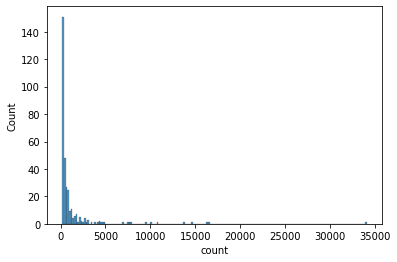

In [51]:
sns.histplot(data=df_200, x="count");

In [52]:
# for each of these words, let's find 200 sentences where they appear

In [53]:
reference_list = df_200["word"].to_list()
len(reference_list)

325

In [54]:
X = []
y = []
for sentence in data:
    words = sentence.split()
    for idx, word in enumerate(words):
        if word in reference_list:
            X.append(words[:idx])
            y.append(word)

In [55]:
df_X_y = pd.DataFrame({
    "X" : X,
    "y" : y
})
df_X_y.head()

,X,y
0,[],this
1,[this],film
2,"[this, film]",was
3,"[this, film, was]",just
4,"[this, film, was, just, brilliant, casting, lo...",story


In [56]:
df_X_y["len"] = df_X_y["X"].apply(len)
df_X_y.head()

,X,y,len
0,[],this,0
1,[this],film,1
2,"[this, film]",was,2
3,"[this, film, was]",just,3
4,"[this, film, was, just, brilliant, casting, lo...",story,8


In [57]:
df_X_y.sort_values(by="len", ascending=False, inplace=True)
df_X_y = df_X_y[df_X_y["len"] > 0].reset_index(drop=True)
df_X_y.head()

,X,y,len
0,"[spoilers, br, br, before, i, begin, this, let...",the,1626
1,"[spoilers, br, br, before, i, begin, this, let...",from,1625
2,"[spoilers, br, br, before, i, begin, this, let...",a,1622
3,"[spoilers, br, br, before, i, begin, this, let...",movie,1620
4,"[spoilers, br, br, before, i, begin, this, let...",this,1619


In [59]:
df_X_y_200 = df_X_y.groupby("y").head(200).reset_index(drop=True)
df_X_y_200.head()

,X,y,len
0,"[spoilers, br, br, before, i, begin, this, let...",the,1626
1,"[spoilers, br, br, before, i, begin, this, let...",from,1625
2,"[spoilers, br, br, before, i, begin, this, let...",a,1622
3,"[spoilers, br, br, before, i, begin, this, let...",movie,1620
4,"[spoilers, br, br, before, i, begin, this, let...",this,1619


In [60]:
df_X_y.shape

(384543, 3)

In [61]:
df_X_y_200.shape

(65000, 3)

In [62]:
200 * len(reference_list)

65000

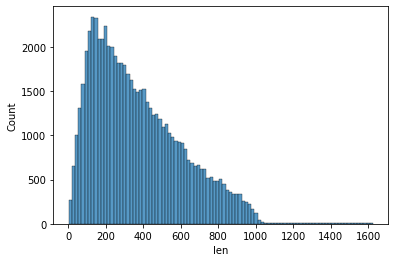

In [64]:
sns.histplot(data = df_X_y_200, x="len");

In [68]:
# now we can use df_X_y_200 to train our model
# (it contains 200 observations for each word)

In [76]:
df_X_y_200.shape

(65000, 3)

In [93]:
n= 64503
" ".join(df_X_y_200.loc[n]["X"]), df_X_y_200.loc[n]["y"]

("what we have here is a damn good little nineties thriller that while perhaps lacking in substance still provides great entertainment throughout it's running time and overall does",
 'everything')

In [87]:
df_X_y_200.tail()

,X,y,len
64995,"[i, have, recently]",watched,3
64996,"[i'm, a, big]",fan,3
64997,"[i'm, not, a]",fan,3
64998,"[i'm, a, big]",fan,3
64999,"[being, a, big]",fan,3


In [94]:
# one last thing: let's limit X to 20 words
df_X_y_200["X_trimed"] = df_X_y_200["X"].apply(lambda x: x[-20:] if len(x)>20 else x)
df_X_y_200.head()

,X,y,len,X_trimed
0,"[spoilers, br, br, before, i, begin, this, let...",the,1626,"[king, and, stick, it, down, in, the, kiddie, ..."
1,"[spoilers, br, br, before, i, begin, this, let...",from,1625,"[by, king, and, stick, it, down, in, the, kidd..."
2,"[spoilers, br, br, before, i, begin, this, let...",a,1622,"[authorized, version, done, by, king, and, sti..."
3,"[spoilers, br, br, before, i, begin, this, let...",movie,1620,"[the, 1997, authorized, version, done, by, kin..."
4,"[spoilers, br, br, before, i, begin, this, let...",this,1619,"[take, the, 1997, authorized, version, done, b..."


In [95]:
n= 64503
" ".join(df_X_y_200.loc[n]["X_trimed"]), df_X_y_200.loc[n]["y"]

("little nineties thriller that while perhaps lacking in substance still provides great entertainment throughout it's running time and overall does",
 'everything')

In [103]:
n= 100
" ".join(df_X_y_200.loc[n]["X_trimed"]), df_X_y_200.loc[n]["y"]

("br nicholson's final assault on his family with an axe was perhaps one of the scariest scenes of movie history",
 'his')